The [NHS Dictionary of Medicines and Devices](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/) designates certain medicines as hospital only as the manufacturer has specified it should generally be used in hospitals. This measure suports review and audit of appropriateness as sometimes they may be selected in error for example zuclopenthixol acetate [(blog here)](https://ebmdatalab.net/zuclopenthixol-acetate-a-new-kind-of-measure-on-openprescribing/).

We have undertaken [detailed analysis here](https://github.com/ebmdatalab/dmd-hosp-only) and it is proposed that one of the outputs is a measure to suppport audit and review of "hospital only" prescribing in primary care.

## Proposed Measure

**Title**: Hospital Only Prescribing

**Definition**: Primary care prescribing of Hospital Only medicines as designated by the NHS Dictionary of Medicines and Devices per 1000 patients

**Why It matters**: The [NHS Dictionary of Medicines and Devices](https://ebmdatalab.net/what-is-the-dmd-the-nhs-dictionary-of-medicines-and-devices/) designates certain medicines as hospital only as the manufacturer has specified it should generally be used in hospitals. This measure suports review and audit of appropriateness as sometimes they may be selected in error for example zuclopenthixol acetate [(blog here)](https://ebmdatalab.net/zuclopenthixol-acetate-a-new-kind-of-measure-on-openprescribing/).

**Numerator**: Number of "hospital only" (as designated by dm+d) items prescribed in primary care. 

**Denominator**: list size, per 1000 paient

## SQL and Results

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
  month,
  practice,
  pct,
  bnf_name,
  bnf_code,
  SUM(items) AS total_items
FROM
  hscic.normalised_prescribing_standard
INNER JOIN
  hscic.practices pract
ON
  practice = pract.code
WHERE
  pract.setting = 4
  AND bnf_code IN (
  SELECT
    DISTINCT(bnf_code)
  FROM
    ebmdatalab.staging_measures.dmd_objs_hospital_only
  WHERE
    bnf_code NOT LIKE '0406000S0%CAC' -- Ondansetron HCl_Tab 8mg
    AND bnf_code NOT LIKE '0408010F0%BAB' -- Clonazepam_Tab 500mcg
    AND bnf_code NOT LIKE '0408010F0%CAC' -- Clonazepam_Tab 2mg
    AND bnf_code NOT LIKE '0703021Q0%AAAA' -- Desogestrel_Tab 75mcg
    AND bnf_code NOT LIKE '0704050R0AAABAB' -- Tadalafil_Tab 20mg
    )
GROUP BY
  practice,
  pct,
  month,
  bnf_name,
  bnf_code
ORDER BY
  practice,
  month
'''




df_dmd_hosp = bq.cached_read(sql, csv_path='dmd_hosp_only.csv')
df_dmd_hosp['month'] = df_dmd_hosp['month'].astype('datetime64[ns]')
df_dmd_hosp.head(3)

,month,practice,pct,bnf_name,bnf_code,total_items
0,2011-01-01,A81001,00K,Midazolam HCl_Inj 2mg/ml 5ml Amp,1501041T0AAABAB,1
1,2011-07-01,A81001,00K,Midazolam HCl_Inj 2mg/ml 5ml Amp,1501041T0AAABAB,1
2,2013-12-01,A81001,00K,Oxycodone HCl_Inj 10mg/ml 1ml Amp,0407020ADAAALAL,1


(0, 13602.95)

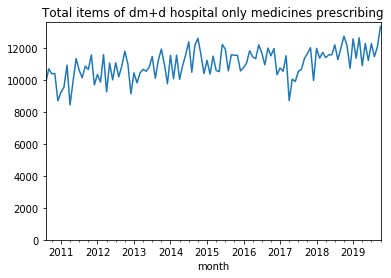

In [3]:
df_dmd_hosp.groupby("month")['total_items'].sum().plot(kind='line', title="Total items of dm+d hospital only medicines prescribing")
plt.ylim(0, )

In [4]:
sql2 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql2, csv_path='listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2014-11-01,NaN,0.000000
1,2014-11-01,00C,7616.000000
2,2014-11-01,00D,5662.509804
3,2014-11-01,00F,6102.176471
4,2014-11-01,00G,8058.750000


In [5]:
ccg_total_hosp = df_dmd_hosp.groupby(["month", "pct"])["total_items"].sum().reset_index()
ccg_total_hosp.head()

,month,pct,total_items
0,2010-08-01,00C,17
1,2010-08-01,00D,71
2,2010-08-01,00J,64
3,2010-08-01,00K,62
4,2010-08-01,00L,61


In [6]:
hosp_df_1000 = pd.merge(ccg_total_hosp, df_list, on=['month', 'pct'])
hosp_df_1000['items_per_1000'] = 1000* (hosp_df_1000['total_items']/hosp_df_1000['list_size'])
hosp_df_1000.head(5)

,month,pct,total_items,list_size,items_per_1000
0,2014-11-01,00C,10,7616.000000,1.313025
1,2014-11-01,00D,85,5662.509804,15.011012
2,2014-11-01,00J,96,6094.536585,15.751813
3,2014-11-01,00K,48,6354.130435,7.554141
4,2014-11-01,00L,73,6852.085106,10.653691


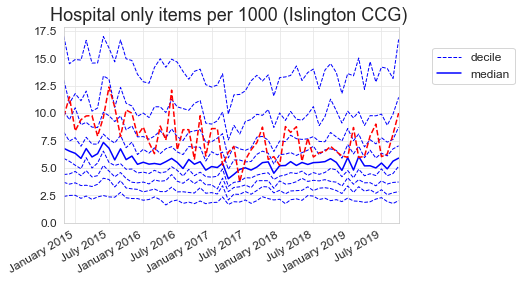

In [7]:
#create sample deciles & prototype measure
charts.deciles_chart(
        hosp_df_1000,
        period_column='month',
        column='items_per_1000',
        title="Hospital only items per 1000 (Islington CCG) ",
        show_outer_percentiles=False)

#add in example CCG (Islington)
df_subject = hosp_df_1000.loc[hosp_df_1000['pct'] == '08H']
plt.plot(df_subject['month'], df_subject['items_per_1000'], 'r--')

plt.show()

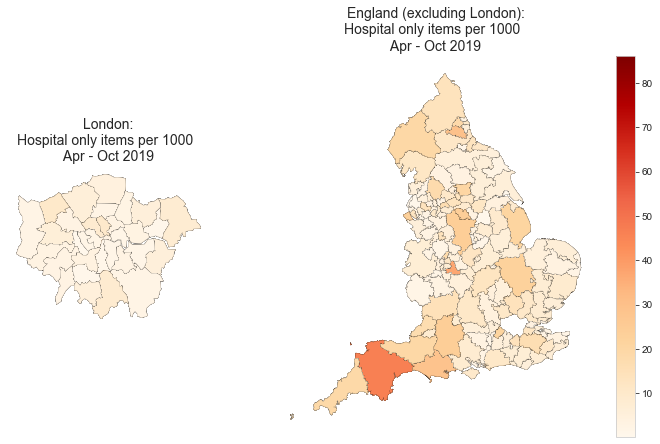

In [8]:

#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_hosp_df_1000 = hosp_df_1000.loc[(hosp_df_1000['month'] >= '2019-04-01') & (hosp_df_1000['month'] <= '2019-10-01')]
plt = maps.ccg_map(latest_hosp_df_1000, title="Hospital only items per 1000  \n Apr - Oct 2019 ", column='items_per_1000', separate_london=True)
plt.show()